In [1]:
import pandas as pd
import numpy as np

import numpy as np
from sklearn.model_selection import train_test_split, KFold
import optuna
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

from tqdm import tqdm

<Axes: ylabel='Frequency'>

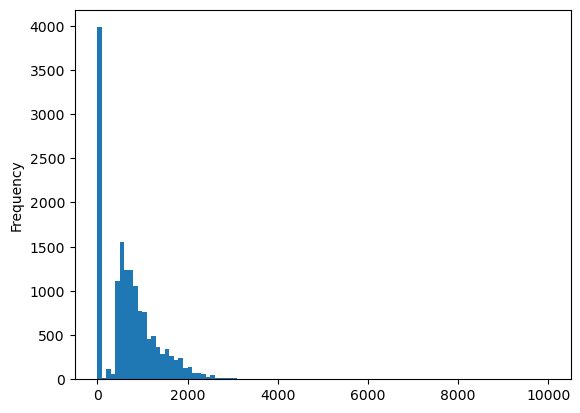

In [38]:
train = pd.read_csv('./open/train.csv').drop('ID',axis=1)
train = train[train['Age'] > 14]
train = train[train['Employment_Status'] != 'Not Working']
train = train[train['Industry_Status'] != 'Not in universe or children']
train['Income'].plot.hist(bins=100)

In [6]:
# train = pd.read_csv('./open/train.csv').drop('ID',axis=1)
# test = pd.read_csv('./open/test.csv').drop('ID',axis=1)

# for column in tqdm(train.columns):
#     if train[column].dtype == 'object' and train[column].nunique() <= 4:  # 가짓수가 4 이상인 경우
#         encoded = pd.get_dummies(train[column], prefix=column)
#         train = pd.concat([train.drop(column, axis=1), encoded], axis=1)

# train

100%|█████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 162.50it/s]


,Age,Gender,Working_Week (Yearly),Gains,Losses,Dividends,Income_Status,Income,Education_Status_Associates degree (Academic),Education_Status_Associates degree (Vocational),...,Birth_Country (Mother)_US,Birth_Country (Mother)_Unknown,Birth_Country (Mother)_Vietnam,Birth_Country (Mother)_Yugoslavia,Tax_Status_Head of Household (HOH),Tax_Status_Married Filling Jointly both over 65 (MFJ),Tax_Status_Married Filling Jointly both under 65 (MFJ),Tax_Status_Married Filling Jointly one over 65 & one under 65 (MFJ),Tax_Status_Nonfiler,Tax_Status_Single
0,63,M,4,0,0,0,Unknown,425,0,0,...,1,0,0,0,0,0,0,0,1,0
1,37,M,52,0,0,0,Under Median,0,0,1,...,1,0,0,0,0,0,0,0,0,1
2,58,F,52,3411,0,0,Under Median,860,0,0,...,1,0,0,0,0,0,1,0,0,0
3,44,M,52,0,0,0,Under Median,850,0,0,...,1,0,0,0,0,0,0,0,0,1
4,37,F,52,0,0,0,Unknown,570,0,0,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,33,M,52,0,0,0,Under Median,1300,0,0,...,1,0,0,0,0,0,0,0,0,1
19996,20,F,12,0,0,0,Under Median,850,0,0,...,0,0,0,0,0,0,0,0,1,0
19997,22,M,52,0,0,0,Unknown,999,0,0,...,1,0,0,0,0,0,0,0,0,1
19998,76,F,0,0,0,0,Under Median,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [382]:
from pycaret.regression import *

train = pd.read_csv('./open/train.csv')
test = pd.read_csv('./open/test.csv')

# object_columns = train.select_dtypes(include=['object']).columns
# for i in object_columns:
#     train[i] = train[i].astype('category')
#     test[i] = test[i].astype('category')

data = train[(train['Age'] > 15) & (train['Income'] < 3000) & (train['Income'] > 0)]
data = data.drop('ID',axis=1)
# PyCaret 회귀 모델 설정
regression_setup = setup(data, target='Income',
                         max_encoding_ohe=2,
                         train_size=0.8,
                         fold=10,
                         session_id=42)

# 다양한 회귀 모델 비교
best_model = compare_models(n_select=3, sort='RMSE')

,Description,Value
0,Session id,42
1,Target,Income
2,Target type,Regression
3,Original data shape,"(11145, 22)"
4,Transformed data shape,"(11145, 22)"
5,Transformed train set shape,"(8916, 22)"
6,Transformed test set shape,"(2229, 22)"
7,Ordinal features,1
8,Numeric features,5
9,Categorical features,16


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,245.3501,116540.8445,341.1393,0.4830,0.3453,0.3015,0.1380
gbr,Gradient Boosting Regressor,247.8585,116648.9367,341.2743,0.4825,0.3484,0.3070,0.3120
catboost,CatBoost Regressor,246.1275,117163.0712,342.0395,0.4803,0.3463,0.3018,1.1970
rf,Random Forest Regressor,255.7584,124433.9414,352.4927,0.4478,0.3581,0.3171,0.7710
xgboost,Extreme Gradient Boosting,254.6904,124953.4822,353.2407,0.4457,0.3581,0.3118,0.3330
lr,Linear Regression,269.2051,128653.5888,358.3658,0.4295,0.3818,0.3395,0.6470
ridge,Ridge Regression,269.2051,128653.6226,358.3658,0.4295,0.3818,0.3395,0.1050
lasso,Lasso Regression,269.2111,128660.6103,358.3749,0.4295,0.3816,0.3395,0.1070
llar,Lasso Least Angle Regression,269.2111,128660.6274,358.3749,0.4295,0.3816,0.3395,0.0990
lar,Least Angle Regression,269.2638,128685.2041,358.4103,0.4294,0.3820,0.3396,0.1000


In [388]:
train = pd.read_csv('./open/train.csv').drop('ID',axis=1)
test = pd.read_csv('./open/test.csv')
test = test.fillna('Householder')

train['Working_Week (Yearly)'] = train['Working_Week (Yearly)'].astype('int32')
test['Working_Week (Yearly)'] = test['Working_Week (Yearly)'].astype('int32')

object_columns = train.select_dtypes(include=['object']).columns

for i in object_columns:
    train[i] = train[i].astype('category')
    test[i] = test[i].astype('category')

data = train[(train['Age'] > 15) & (train['Income'] < 3000)]
X = data.drop('Income',axis=1)
y = data[['Income']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

def objective(trial):
    # 하이퍼파라미터 검색 범위 지정
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100)
    }
    
    # 교차 검증 설정 (5-Fold 교차 검증 사용)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    rmse_scores = []

    for train_index, valid_index in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_index], X_train.iloc[valid_index]
        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[valid_index]

        # LightGBM 모델 정의
        model = lgb.LGBMRegressor(**params)

        # 모델 훈련
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], early_stopping_rounds=100, verbose=False)

        # 검증 데이터로 RMSE 계산
        y_pred = model.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        rmse_scores.append(rmse)

    # 교차 검증 평균 RMSE 반환
    return np.mean(rmse_scores)

# Optuna 최적화 실행
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

[I 2024-03-18 05:05:32,022] A new study created in memory with name: no-name-6871c68b-fcae-4edd-9563-98bd09dd2fd4


[LightGBM] [Warning] feature_fraction is set=0.44928930303151626, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44928930303151626
[LightGBM] [Warning] bagging_fraction is set=0.4673279808747005, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4673279808747005
[LightGBM] [Warning] lambda_l1 is set=0.04920092081260944, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04920092081260944
[LightGBM] [Warning] lambda_l2 is set=3.011643705944981e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.011643705944981e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.44928930303151626, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44928930303151626
[LightGBM] [Warning] bagging_fraction is set=0.4673279808747005, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4673279808747005
[LightGBM] 

[I 2024-03-18 05:05:32,987] Trial 0 finished with value: 592.038070183464 and parameters: {'lambda_l1': 0.04920092081260944, 'lambda_l2': 3.011643705944981e-08, 'num_leaves': 35, 'learning_rate': 1.1170055205398276e-08, 'feature_fraction': 0.44928930303151626, 'bagging_fraction': 0.4673279808747005, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 0 with value: 592.038070183464.


[LightGBM] [Warning] feature_fraction is set=0.9623382320388347, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9623382320388347
[LightGBM] [Warning] bagging_fraction is set=0.7972653351333949, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7972653351333949
[LightGBM] [Warning] lambda_l1 is set=0.0021861331971641945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0021861331971641945
[LightGBM] [Warning] lambda_l2 is set=7.143227235179982e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.143227235179982e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9623382320388347, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9623382320388347
[LightGBM] [Warning] bagging_fraction is set=0.7972653351333949, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7972653351333949
[LightGBM] 

[I 2024-03-18 05:05:34,470] Trial 1 finished with value: 592.0280263317054 and parameters: {'lambda_l1': 0.0021861331971641945, 'lambda_l2': 7.143227235179982e-07, 'num_leaves': 165, 'learning_rate': 5.817318743785632e-07, 'feature_fraction': 0.9623382320388347, 'bagging_fraction': 0.7972653351333949, 'bagging_freq': 4, 'min_child_samples': 80}. Best is trial 1 with value: 592.0280263317054.


[LightGBM] [Warning] feature_fraction is set=0.982749985050674, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.982749985050674
[LightGBM] [Warning] bagging_fraction is set=0.5101962423961534, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5101962423961534
[LightGBM] [Warning] lambda_l1 is set=1.2199289913957339e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2199289913957339e-05
[LightGBM] [Warning] lambda_l2 is set=0.634438203189294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.634438203189294
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.982749985050674, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.982749985050674
[LightGBM] [Warning] bagging_fraction is set=0.5101962423961534, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5101962423961534
[LightGBM] [Warning] 

[I 2024-03-18 05:05:36,294] Trial 2 finished with value: 591.9310724437071 and parameters: {'lambda_l1': 1.2199289913957339e-05, 'lambda_l2': 0.634438203189294, 'num_leaves': 243, 'learning_rate': 6.1371675205864765e-06, 'feature_fraction': 0.982749985050674, 'bagging_fraction': 0.5101962423961534, 'bagging_freq': 4, 'min_child_samples': 25}. Best is trial 2 with value: 591.9310724437071.


[LightGBM] [Warning] feature_fraction is set=0.6717774227254463, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6717774227254463
[LightGBM] [Warning] bagging_fraction is set=0.4567011711610716, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4567011711610716
[LightGBM] [Warning] lambda_l1 is set=3.927282958694539, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.927282958694539
[LightGBM] [Warning] lambda_l2 is set=0.30144833122111175, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.30144833122111175
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6717774227254463, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6717774227254463
[LightGBM] [Warning] bagging_fraction is set=0.4567011711610716, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4567011711610716
[LightGBM] [Warning] la

[I 2024-03-18 05:05:36,871] Trial 3 finished with value: 497.8113026899902 and parameters: {'lambda_l1': 3.927282958694539, 'lambda_l2': 0.30144833122111175, 'num_leaves': 11, 'learning_rate': 0.7729580930637243, 'feature_fraction': 0.6717774227254463, 'bagging_fraction': 0.4567011711610716, 'bagging_freq': 6, 'min_child_samples': 26}. Best is trial 3 with value: 497.8113026899902.


[LightGBM] [Warning] feature_fraction is set=0.6717774227254463, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6717774227254463
[LightGBM] [Warning] bagging_fraction is set=0.4567011711610716, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4567011711610716
[LightGBM] [Warning] lambda_l1 is set=3.927282958694539, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.927282958694539
[LightGBM] [Warning] lambda_l2 is set=0.30144833122111175, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.30144833122111175
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6561149772112449, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6561149772112449
[LightGBM] [Warning] bagging_fraction is set=0.5596182700491776, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5596182700491776
[LightGBM] [Warning] la

[I 2024-03-18 05:05:38,913] Trial 4 finished with value: 591.151231021978 and parameters: {'lambda_l1': 0.019865130170499064, 'lambda_l2': 0.0001165469007085689, 'num_leaves': 148, 'learning_rate': 5.344006359631106e-05, 'feature_fraction': 0.6561149772112449, 'bagging_fraction': 0.5596182700491776, 'bagging_freq': 3, 'min_child_samples': 15}. Best is trial 3 with value: 497.8113026899902.


[LightGBM] [Warning] feature_fraction is set=0.5877356238007928, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5877356238007928
[LightGBM] [Warning] bagging_fraction is set=0.44908561309587824, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44908561309587824
[LightGBM] [Warning] lambda_l1 is set=0.15088229175020704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15088229175020704
[LightGBM] [Warning] lambda_l2 is set=0.21975034990958606, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.21975034990958606
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5877356238007928, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5877356238007928
[LightGBM] [Warning] bagging_fraction is set=0.44908561309587824, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44908561309587824
[LightGBM] [War

[I 2024-03-18 05:05:39,986] Trial 5 finished with value: 589.2550461459086 and parameters: {'lambda_l1': 0.15088229175020704, 'lambda_l2': 0.21975034990958606, 'num_leaves': 70, 'learning_rate': 0.00018691586719834014, 'feature_fraction': 0.5877356238007928, 'bagging_fraction': 0.44908561309587824, 'bagging_freq': 1, 'min_child_samples': 84}. Best is trial 3 with value: 497.8113026899902.


[LightGBM] [Warning] feature_fraction is set=0.49969856208311136, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49969856208311136
[LightGBM] [Warning] bagging_fraction is set=0.5055723176119016, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5055723176119016
[LightGBM] [Warning] lambda_l1 is set=1.3749643812788077, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3749643812788077
[LightGBM] [Warning] lambda_l2 is set=2.93214298535026e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.93214298535026e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.49969856208311136, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49969856208311136
[LightGBM] [Warning] bagging_fraction is set=0.5055723176119016, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5055723176119016
[LightGBM] [War

[I 2024-03-18 05:05:41,191] Trial 6 finished with value: 592.0065004167107 and parameters: {'lambda_l1': 1.3749643812788077, 'lambda_l2': 2.93214298535026e-05, 'num_leaves': 124, 'learning_rate': 2.235024487846871e-06, 'feature_fraction': 0.49969856208311136, 'bagging_fraction': 0.5055723176119016, 'bagging_freq': 2, 'min_child_samples': 59}. Best is trial 3 with value: 497.8113026899902.


[LightGBM] [Warning] feature_fraction is set=0.900799741399588, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.900799741399588
[LightGBM] [Warning] bagging_fraction is set=0.605601009574425, subsample=1.0 will be ignored. Current value: bagging_fraction=0.605601009574425
[LightGBM] [Warning] lambda_l1 is set=0.011755215118817518, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011755215118817518
[LightGBM] [Warning] lambda_l2 is set=0.005158862143063499, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005158862143063499
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.900799741399588, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.900799741399588
[LightGBM] [Warning] bagging_fraction is set=0.605601009574425, subsample=1.0 will be ignored. Current value: bagging_fraction=0.605601009574425
[LightGBM] [Warning] la

[I 2024-03-18 05:05:43,375] Trial 7 finished with value: 563.8199926667443 and parameters: {'lambda_l1': 0.011755215118817518, 'lambda_l2': 0.005158862143063499, 'num_leaves': 146, 'learning_rate': 0.0018479948535020968, 'feature_fraction': 0.900799741399588, 'bagging_fraction': 0.605601009574425, 'bagging_freq': 7, 'min_child_samples': 11}. Best is trial 3 with value: 497.8113026899902.


[LightGBM] [Warning] feature_fraction is set=0.4299884485874469, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4299884485874469
[LightGBM] [Warning] bagging_fraction is set=0.5604223050838191, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5604223050838191
[LightGBM] [Warning] lambda_l1 is set=1.6075351049544288e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6075351049544288e-06
[LightGBM] [Warning] lambda_l2 is set=0.009780498254981358, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009780498254981358
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4299884485874469, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4299884485874469
[LightGBM] [Warning] bagging_fraction is set=0.5604223050838191, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5604223050838191
[LightGBM] 

[I 2024-03-18 05:05:45,040] Trial 8 finished with value: 489.4016951387657 and parameters: {'lambda_l1': 1.6075351049544288e-06, 'lambda_l2': 0.009780498254981358, 'num_leaves': 124, 'learning_rate': 0.10891178313077096, 'feature_fraction': 0.4299884485874469, 'bagging_fraction': 0.5604223050838191, 'bagging_freq': 2, 'min_child_samples': 22}. Best is trial 8 with value: 489.4016951387657.


[LightGBM] [Warning] feature_fraction is set=0.5402704304284539, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5402704304284539
[LightGBM] [Warning] bagging_fraction is set=0.6061539654358354, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6061539654358354
[LightGBM] [Warning] lambda_l1 is set=5.593090168933762e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.593090168933762e-05
[LightGBM] [Warning] lambda_l2 is set=1.7328612637107719, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7328612637107719
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5402704304284539, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5402704304284539
[LightGBM] [Warning] bagging_fraction is set=0.6061539654358354, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6061539654358354
[LightGBM] [Warni

[I 2024-03-18 05:05:46,295] Trial 9 finished with value: 592.0380065447902 and parameters: {'lambda_l1': 5.593090168933762e-05, 'lambda_l2': 1.7328612637107719, 'num_leaves': 55, 'learning_rate': 1.4654042925943799e-08, 'feature_fraction': 0.5402704304284539, 'bagging_fraction': 0.6061539654358354, 'bagging_freq': 4, 'min_child_samples': 29}. Best is trial 8 with value: 489.4016951387657.


[LightGBM] [Warning] feature_fraction is set=0.7883334749330522, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7883334749330522
[LightGBM] [Warning] bagging_fraction is set=0.9859882893040115, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9859882893040115
[LightGBM] [Warning] lambda_l1 is set=1.3044827415593651e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3044827415593651e-08
[LightGBM] [Warning] lambda_l2 is set=0.007838875701624991, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007838875701624991
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7883334749330522, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7883334749330522
[LightGBM] [Warning] bagging_fraction is set=0.9859882893040115, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9859882893040115
[LightGBM] 

[I 2024-03-18 05:05:48,317] Trial 10 finished with value: 487.9879193106458 and parameters: {'lambda_l1': 1.3044827415593651e-08, 'lambda_l2': 0.007838875701624991, 'num_leaves': 229, 'learning_rate': 0.10592589848896111, 'feature_fraction': 0.7883334749330522, 'bagging_fraction': 0.9859882893040115, 'bagging_freq': 1, 'min_child_samples': 54}. Best is trial 10 with value: 487.9879193106458.


[LightGBM] [Warning] feature_fraction is set=0.810330456200337, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.810330456200337
[LightGBM] [Warning] bagging_fraction is set=0.9998117675222017, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9998117675222017
[LightGBM] [Warning] lambda_l1 is set=1.5979322787426726e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5979322787426726e-08
[LightGBM] [Warning] lambda_l2 is set=0.004599820474540839, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004599820474540839
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.810330456200337, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.810330456200337
[LightGBM] [Warning] bagging_fraction is set=0.9998117675222017, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9998117675222017
[LightGBM] [War

[I 2024-03-18 05:05:50,432] Trial 11 finished with value: 492.33045958527526 and parameters: {'lambda_l1': 1.5979322787426726e-08, 'lambda_l2': 0.004599820474540839, 'num_leaves': 253, 'learning_rate': 0.3520054418070429, 'feature_fraction': 0.810330456200337, 'bagging_fraction': 0.9998117675222017, 'bagging_freq': 1, 'min_child_samples': 52}. Best is trial 10 with value: 487.9879193106458.


[LightGBM] [Warning] feature_fraction is set=0.7828517469227855, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7828517469227855
[LightGBM] [Warning] bagging_fraction is set=0.8166886968419942, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8166886968419942
[LightGBM] [Warning] lambda_l1 is set=6.822954536915778e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.822954536915778e-08
[LightGBM] [Warning] lambda_l2 is set=0.004892663329959103, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004892663329959103
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7828517469227855, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7828517469227855
[LightGBM] [Warning] bagging_fraction is set=0.8166886968419942, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8166886968419942
[LightGBM] [W

[I 2024-03-18 05:05:52,204] Trial 12 finished with value: 492.4854965209459 and parameters: {'lambda_l1': 6.822954536915778e-08, 'lambda_l2': 0.004892663329959103, 'num_leaves': 192, 'learning_rate': 0.017345944209256645, 'feature_fraction': 0.7828517469227855, 'bagging_fraction': 0.8166886968419942, 'bagging_freq': 2, 'min_child_samples': 52}. Best is trial 10 with value: 487.9879193106458.


[LightGBM] [Warning] feature_fraction is set=0.7780901819057734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7780901819057734
[LightGBM] [Warning] bagging_fraction is set=0.9907710531091678, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9907710531091678
[LightGBM] [Warning] lambda_l1 is set=1.2687620779013013e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2687620779013013e-06
[LightGBM] [Warning] lambda_l2 is set=0.017270411979005574, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.017270411979005574
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7780901819057734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7780901819057734
[LightGBM] [Warning] bagging_fraction is set=0.9907710531091678, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9907710531091678
[LightGBM] 

[I 2024-03-18 05:05:54,005] Trial 13 finished with value: 487.1858771164625 and parameters: {'lambda_l1': 1.2687620779013013e-06, 'lambda_l2': 0.017270411979005574, 'num_leaves': 96, 'learning_rate': 0.03296854318694259, 'feature_fraction': 0.7780901819057734, 'bagging_fraction': 0.9907710531091678, 'bagging_freq': 2, 'min_child_samples': 67}. Best is trial 13 with value: 487.1858771164625.


[LightGBM] [Warning] feature_fraction is set=0.7896733918407162, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7896733918407162
[LightGBM] [Warning] bagging_fraction is set=0.977921448814016, subsample=1.0 will be ignored. Current value: bagging_fraction=0.977921448814016
[LightGBM] [Warning] lambda_l1 is set=4.3854221257614465e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.3854221257614465e-07
[LightGBM] [Warning] lambda_l2 is set=8.702535977810316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.702535977810316
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7896733918407162, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7896733918407162
[LightGBM] [Warning] bagging_fraction is set=0.977921448814016, subsample=1.0 will be ignored. Current value: bagging_fraction=0.977921448814016
[LightGBM] [Warning] 

[I 2024-03-18 05:05:55,484] Trial 14 finished with value: 497.8984684003708 and parameters: {'lambda_l1': 4.3854221257614465e-07, 'lambda_l2': 8.702535977810316, 'num_leaves': 84, 'learning_rate': 0.014397912144281738, 'feature_fraction': 0.7896733918407162, 'bagging_fraction': 0.977921448814016, 'bagging_freq': 1, 'min_child_samples': 70}. Best is trial 13 with value: 487.1858771164625.


[LightGBM] [Warning] feature_fraction is set=0.8569521964034541, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8569521964034541
[LightGBM] [Warning] bagging_fraction is set=0.8825446046928344, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8825446046928344
[LightGBM] [Warning] lambda_l1 is set=4.67380142414129e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.67380142414129e-07
[LightGBM] [Warning] lambda_l2 is set=1.553027522817695e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.553027522817695e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8569521964034541, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8569521964034541
[LightGBM] [Warning] bagging_fraction is set=0.8825446046928344, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8825446046928344
[LightGBM] [W

[I 2024-03-18 05:05:56,937] Trial 15 finished with value: 554.344805616261 and parameters: {'lambda_l1': 4.67380142414129e-07, 'lambda_l2': 1.553027522817695e-05, 'num_leaves': 213, 'learning_rate': 0.002687499020794679, 'feature_fraction': 0.8569521964034541, 'bagging_fraction': 0.8825446046928344, 'bagging_freq': 3, 'min_child_samples': 99}. Best is trial 13 with value: 487.1858771164625.


[LightGBM] [Warning] feature_fraction is set=0.7335469115945696, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7335469115945696
[LightGBM] [Warning] bagging_fraction is set=0.9137194793840456, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9137194793840456
[LightGBM] [Warning] lambda_l1 is set=1.085510624074885e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.085510624074885e-05
[LightGBM] [Warning] lambda_l2 is set=0.02910270735626463, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02910270735626463
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7335469115945696, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7335469115945696
[LightGBM] [Warning] bagging_fraction is set=0.9137194793840456, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9137194793840456
[LightGBM] [War

[I 2024-03-18 05:05:58,546] Trial 16 finished with value: 486.4169082417578 and parameters: {'lambda_l1': 1.085510624074885e-05, 'lambda_l2': 0.02910270735626463, 'num_leaves': 83, 'learning_rate': 0.04882241746563196, 'feature_fraction': 0.7335469115945696, 'bagging_fraction': 0.9137194793840456, 'bagging_freq': 3, 'min_child_samples': 40}. Best is trial 16 with value: 486.4169082417578.


[LightGBM] [Warning] feature_fraction is set=0.7117357211231912, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7117357211231912
[LightGBM] [Warning] bagging_fraction is set=0.8886971986333535, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8886971986333535
[LightGBM] [Warning] lambda_l1 is set=0.000355808427870898, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000355808427870898
[LightGBM] [Warning] lambda_l2 is set=0.07316848803568525, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07316848803568525
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7117357211231912, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7117357211231912
[LightGBM] [Warning] bagging_fraction is set=0.8886971986333535, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8886971986333535
[LightGBM] [Warni

[I 2024-03-18 05:06:00,226] Trial 17 finished with value: 583.1836419158774 and parameters: {'lambda_l1': 0.000355808427870898, 'lambda_l2': 0.07316848803568525, 'num_leaves': 95, 'learning_rate': 0.000544915199344208, 'feature_fraction': 0.7117357211231912, 'bagging_fraction': 0.8886971986333535, 'bagging_freq': 3, 'min_child_samples': 41}. Best is trial 16 with value: 486.4169082417578.


[LightGBM] [Warning] feature_fraction is set=0.7010206997144648, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7010206997144648
[LightGBM] [Warning] bagging_fraction is set=0.7074193115182149, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7074193115182149
[LightGBM] [Warning] lambda_l1 is set=2.8618722160414204e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8618722160414204e-05
[LightGBM] [Warning] lambda_l2 is set=0.00025605871178084914, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00025605871178084914
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7010206997144648, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7010206997144648
[LightGBM] [Warning] bagging_fraction is set=0.7074193115182149, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7074193115182149
[LightG

[I 2024-03-18 05:06:01,928] Trial 18 finished with value: 492.2502305646159 and parameters: {'lambda_l1': 2.8618722160414204e-05, 'lambda_l2': 0.00025605871178084914, 'num_leaves': 106, 'learning_rate': 0.018260274846522952, 'feature_fraction': 0.7010206997144648, 'bagging_fraction': 0.7074193115182149, 'bagging_freq': 5, 'min_child_samples': 40}. Best is trial 16 with value: 486.4169082417578.


[LightGBM] [Warning] feature_fraction is set=0.6177061954945453, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6177061954945453
[LightGBM] [Warning] bagging_fraction is set=0.9134013319627102, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9134013319627102
[LightGBM] [Warning] lambda_l1 is set=5.1718403126210334e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.1718403126210334e-06
[LightGBM] [Warning] lambda_l2 is set=0.029912553137424486, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.029912553137424486
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6177061954945453, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6177061954945453
[LightGBM] [Warning] bagging_fraction is set=0.9134013319627102, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9134013319627102
[LightGBM] 

[I 2024-03-18 05:06:03,247] Trial 19 finished with value: 591.3819329893812 and parameters: {'lambda_l1': 5.1718403126210334e-06, 'lambda_l2': 0.029912553137424486, 'num_leaves': 46, 'learning_rate': 4.107763980909044e-05, 'feature_fraction': 0.6177061954945453, 'bagging_fraction': 0.9134013319627102, 'bagging_freq': 3, 'min_child_samples': 67}. Best is trial 16 with value: 486.4169082417578.


[LightGBM] [Warning] feature_fraction is set=0.7474585945663034, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7474585945663034
[LightGBM] [Warning] bagging_fraction is set=0.7393546259211479, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7393546259211479
[LightGBM] [Warning] lambda_l1 is set=0.000156001308205818, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000156001308205818
[LightGBM] [Warning] lambda_l2 is set=0.0012134712155497356, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012134712155497356
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7474585945663034, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7474585945663034
[LightGBM] [Warning] bagging_fraction is set=0.7393546259211479, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7393546259211479
[LightGBM] [W

[I 2024-03-18 05:06:04,003] Trial 20 finished with value: 548.2605976137088 and parameters: {'lambda_l1': 0.000156001308205818, 'lambda_l2': 0.0012134712155497356, 'num_leaves': 17, 'learning_rate': 0.0035153209296181517, 'feature_fraction': 0.7474585945663034, 'bagging_fraction': 0.7393546259211479, 'bagging_freq': 2, 'min_child_samples': 41}. Best is trial 16 with value: 486.4169082417578.


[LightGBM] [Warning] feature_fraction is set=0.7474585945663034, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7474585945663034
[LightGBM] [Warning] bagging_fraction is set=0.7393546259211479, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7393546259211479
[LightGBM] [Warning] lambda_l1 is set=0.000156001308205818, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000156001308205818
[LightGBM] [Warning] lambda_l2 is set=0.0012134712155497356, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012134712155497356
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8824328214800454, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8824328214800454
[LightGBM] [Warning] bagging_fraction is set=0.9621510106842701, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9621510106842701
[LightGBM] [W

[I 2024-03-18 05:06:05,944] Trial 21 finished with value: 489.07572547425553 and parameters: {'lambda_l1': 1.7834511654631812e-08, 'lambda_l2': 0.03812056559456666, 'num_leaves': 193, 'learning_rate': 0.12240357355081716, 'feature_fraction': 0.8824328214800454, 'bagging_fraction': 0.9621510106842701, 'bagging_freq': 1, 'min_child_samples': 60}. Best is trial 16 with value: 486.4169082417578.


[LightGBM] [Warning] feature_fraction is set=0.832158173902326, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.832158173902326
[LightGBM] [Warning] bagging_fraction is set=0.9316781956410781, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9316781956410781
[LightGBM] [Warning] lambda_l1 is set=9.049107598291031e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.049107598291031e-08
[LightGBM] [Warning] lambda_l2 is set=0.0006626339664519851, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006626339664519851
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.832158173902326, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.832158173902326
[LightGBM] [Warning] bagging_fraction is set=0.9316781956410781, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9316781956410781
[LightGBM] [War

[I 2024-03-18 05:06:07,730] Trial 22 finished with value: 487.0872141277481 and parameters: {'lambda_l1': 9.049107598291031e-08, 'lambda_l2': 0.0006626339664519851, 'num_leaves': 98, 'learning_rate': 0.06350401874868969, 'feature_fraction': 0.832158173902326, 'bagging_fraction': 0.9316781956410781, 'bagging_freq': 2, 'min_child_samples': 47}. Best is trial 16 with value: 486.4169082417578.


[LightGBM] [Warning] feature_fraction is set=0.8400824715585251, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8400824715585251
[LightGBM] [Warning] bagging_fraction is set=0.838046580989888, subsample=1.0 will be ignored. Current value: bagging_fraction=0.838046580989888
[LightGBM] [Warning] lambda_l1 is set=2.045077129486007e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.045077129486007e-07
[LightGBM] [Warning] lambda_l2 is set=0.00033606386878539584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00033606386878539584
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8400824715585251, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8400824715585251
[LightGBM] [Warning] bagging_fraction is set=0.838046580989888, subsample=1.0 will be ignored. Current value: bagging_fraction=0.838046580989888
[LightGBM] [W

[I 2024-03-18 05:06:09,243] Trial 23 finished with value: 486.74280506907974 and parameters: {'lambda_l1': 2.045077129486007e-07, 'lambda_l2': 0.00033606386878539584, 'num_leaves': 67, 'learning_rate': 0.030277231237870152, 'feature_fraction': 0.8400824715585251, 'bagging_fraction': 0.838046580989888, 'bagging_freq': 2, 'min_child_samples': 45}. Best is trial 16 with value: 486.4169082417578.


[LightGBM] [Warning] feature_fraction is set=0.9225073066714586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9225073066714586
[LightGBM] [Warning] bagging_fraction is set=0.8360589705968204, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8360589705968204
[LightGBM] [Warning] lambda_l1 is set=1.3977148809059288e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3977148809059288e-07
[LightGBM] [Warning] lambda_l2 is set=1.4268021461149052e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4268021461149052e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9225073066714586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9225073066714586
[LightGBM] [Warning] bagging_fraction is set=0.8360589705968204, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8360589705968204
[LightG

[I 2024-03-18 05:06:10,728] Trial 24 finished with value: 526.8232633790249 and parameters: {'lambda_l1': 1.3977148809059288e-07, 'lambda_l2': 1.4268021461149052e-05, 'num_leaves': 68, 'learning_rate': 0.005745440222249534, 'feature_fraction': 0.9225073066714586, 'bagging_fraction': 0.8360589705968204, 'bagging_freq': 3, 'min_child_samples': 39}. Best is trial 16 with value: 486.4169082417578.


[LightGBM] [Warning] feature_fraction is set=0.8408990836017806, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8408990836017806
[LightGBM] [Warning] bagging_fraction is set=0.9222346292329381, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9222346292329381
[LightGBM] [Warning] lambda_l1 is set=3.246710571168627e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.246710571168627e-06
[LightGBM] [Warning] lambda_l2 is set=0.0004666772985280768, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004666772985280768
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8408990836017806, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8408990836017806
[LightGBM] [Warning] bagging_fraction is set=0.9222346292329381, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9222346292329381
[LightGBM] 

[I 2024-03-18 05:06:12,721] Trial 25 finished with value: 581.3900636386785 and parameters: {'lambda_l1': 3.246710571168627e-06, 'lambda_l2': 0.0004666772985280768, 'num_leaves': 112, 'learning_rate': 0.0006368552178645821, 'feature_fraction': 0.8408990836017806, 'bagging_fraction': 0.9222346292329381, 'bagging_freq': 2, 'min_child_samples': 46}. Best is trial 16 with value: 486.4169082417578.


[LightGBM] [Warning] feature_fraction is set=0.8483633368445789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8483633368445789
[LightGBM] [Warning] bagging_fraction is set=0.8522951206054802, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8522951206054802
[LightGBM] [Warning] lambda_l1 is set=1.1984782717911841e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1984782717911841e-07
[LightGBM] [Warning] lambda_l2 is set=4.977904923570519e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.977904923570519e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8483633368445789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8483633368445789
[LightGBM] [Warning] bagging_fraction is set=0.8522951206054802, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8522951206054802
[LightGBM

[I 2024-03-18 05:06:14,113] Trial 26 finished with value: 503.1671096655415 and parameters: {'lambda_l1': 1.1984782717911841e-07, 'lambda_l2': 4.977904923570519e-07, 'num_leaves': 75, 'learning_rate': 0.895622554993633, 'feature_fraction': 0.8483633368445789, 'bagging_fraction': 0.8522951206054802, 'bagging_freq': 5, 'min_child_samples': 34}. Best is trial 16 with value: 486.4169082417578.


[LightGBM] [Warning] feature_fraction is set=0.7343572587149507, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7343572587149507
[LightGBM] [Warning] bagging_fraction is set=0.7593257677252608, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7593257677252608
[LightGBM] [Warning] lambda_l1 is set=4.143231431727686e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.143231431727686e-07
[LightGBM] [Warning] lambda_l2 is set=0.0011042645091498126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011042645091498126
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7343572587149507, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7343572587149507
[LightGBM] [Warning] bagging_fraction is set=0.7593257677252608, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7593257677252608
[LightGBM] 

[I 2024-03-18 05:06:15,274] Trial 27 finished with value: 485.508223575266 and parameters: {'lambda_l1': 4.143231431727686e-07, 'lambda_l2': 0.0011042645091498126, 'num_leaves': 40, 'learning_rate': 0.05322702393852342, 'feature_fraction': 0.7343572587149507, 'bagging_fraction': 0.7593257677252608, 'bagging_freq': 3, 'min_child_samples': 34}. Best is trial 27 with value: 485.508223575266.


[LightGBM] [Warning] feature_fraction is set=0.7343572587149507, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7343572587149507
[LightGBM] [Warning] bagging_fraction is set=0.7593257677252608, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7593257677252608
[LightGBM] [Warning] lambda_l1 is set=4.143231431727686e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.143231431727686e-07
[LightGBM] [Warning] lambda_l2 is set=0.0011042645091498126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011042645091498126
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7398792500099147, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7398792500099147
[LightGBM] [Warning] bagging_fraction is set=0.7608470175892795, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7608470175892795
[LightGBM] 

[I 2024-03-18 05:06:16,324] Trial 28 finished with value: 516.2711792885317 and parameters: {'lambda_l1': 0.00044490890608957483, 'lambda_l2': 7.440152546802422e-05, 'num_leaves': 36, 'learning_rate': 0.007932129934540623, 'feature_fraction': 0.7398792500099147, 'bagging_fraction': 0.7608470175892795, 'bagging_freq': 5, 'min_child_samples': 16}. Best is trial 27 with value: 485.508223575266.


[LightGBM] [Warning] feature_fraction is set=0.7398792500099147, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7398792500099147
[LightGBM] [Warning] bagging_fraction is set=0.7608470175892795, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7608470175892795
[LightGBM] [Warning] lambda_l1 is set=0.00044490890608957483, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00044490890608957483
[LightGBM] [Warning] lambda_l2 is set=7.440152546802422e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.440152546802422e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6372928621970345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6372928621970345
[LightGBM] [Warning] bagging_fraction is set=0.7752439062613136, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7752439062613136
[LightGBM

[I 2024-03-18 05:06:17,253] Trial 29 finished with value: 486.87704669672314 and parameters: {'lambda_l1': 1.1546498414355338e-05, 'lambda_l2': 2.375069793951118e-06, 'num_leaves': 26, 'learning_rate': 0.15327470624315465, 'feature_fraction': 0.6372928621970345, 'bagging_fraction': 0.7752439062613136, 'bagging_freq': 3, 'min_child_samples': 33}. Best is trial 27 with value: 485.508223575266.


[LightGBM] [Warning] feature_fraction is set=0.6372928621970345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6372928621970345
[LightGBM] [Warning] bagging_fraction is set=0.7752439062613136, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7752439062613136
[LightGBM] [Warning] lambda_l1 is set=1.1546498414355338e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1546498414355338e-05
[LightGBM] [Warning] lambda_l2 is set=2.375069793951118e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.375069793951118e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


In [389]:
study.best_value

485.508223575266

In [26]:
train = pd.read_csv('./open/train.csv').drop('ID',axis=1)
test = pd.read_csv('./open/test.csv')
test = test.fillna('Householder')

train['Working_Week (Yearly)'] = train['Working_Week (Yearly)'].astype('int32')
test['Working_Week (Yearly)'] = test['Working_Week (Yearly)'].astype('int32')

object_columns = train.select_dtypes(include=['object']).columns

for i in object_columns:
    train[i] = train[i].astype('category')
    test[i] = test[i].astype('category')

data = train[(train['Age'] > 15) & (train['Income'] < 3000)]
X = data.drop('Income',axis=1)
y = data[['Income']]


lgb_model = lgb.LGBMRegressor(bagging_fraction=0.8205263711474302, bagging_freq=1,
              feature_fraction=0.8234703314292054,
              lambda_l1=0.02376856687184958, lambda_l2=1.2645848339107883e-08,
              learning_rate=0.03373139521340064, min_child_samples=39)
lgb_model.fit(X,y)

[LightGBM] [Warning] feature_fraction is set=0.8234703314292054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8234703314292054
[LightGBM] [Warning] bagging_fraction is set=0.8205263711474302, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8205263711474302
[LightGBM] [Warning] lambda_l1 is set=0.02376856687184958, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02376856687184958
[LightGBM] [Warning] lambda_l2 is set=1.2645848339107883e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2645848339107883e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


LGBMRegressor(bagging_fraction=0.8205263711474302, bagging_freq=1,
              feature_fraction=0.8234703314292054,
              lambda_l1=0.02376856687184958, lambda_l2=1.2645848339107883e-08,
              learning_rate=0.03373139521340064, min_child_samples=39)

In [361]:
# import catboost
# cat_model = catboost.CatBoostRegressor(random_state=42,cat_features=list(X.select_dtypes(include=['category']).columns))
# cat_model.fit(X,y)

In [31]:
pred = 1*lgb_model.predict(test.drop('ID',axis=1)) # + 0.3*cat_model.predict(test.drop('ID',axis=1))
for i in test[(test['Age'] < 15)].index:
    pred[i] = 0
for i in test[(test['Employment_Status'] == 'Not Working')].index:
    pred[i] = 0
for i in test[(test['Industry_Status'] == 'Not in universe or children')].index:
    pred[i] = 0
    
for i in test[test['Working_Week (Yearly)'] == 0].index:
    pred[i] = 0

for i in range(len(pred)):
    if pred[i] < 0:
        pred[i] = 0
print(len([i for i in pred if i == 0])/len(test))
print(len([i for i in train['Income'] if i == 0])/len(train))
pred

0.2561
0.43485


array([  0.        ,   0.        , 433.54990571, ..., 378.38457004,
         0.        , 511.23591636])

(array([2.000e+00, 1.000e+00, 2.000e+00, 2.000e+00, 1.667e+03, 5.940e+02,
        3.100e+01, 2.500e+01, 5.000e+00, 1.000e+00, 3.000e+00, 2.000e+00,
        5.000e+00, 9.000e+00, 7.000e+00, 4.000e+00, 7.000e+00, 5.000e+00,
        1.000e+01, 1.000e+01, 1.200e+01, 1.700e+01, 3.900e+01, 5.200e+01,
        7.800e+01, 1.020e+02, 1.690e+02, 1.660e+02, 1.780e+02, 2.230e+02,
        2.580e+02, 2.350e+02, 2.560e+02, 2.560e+02, 2.880e+02, 2.570e+02,
        2.020e+02, 2.220e+02, 1.660e+02, 2.220e+02, 1.870e+02, 2.200e+02,
        2.380e+02, 2.450e+02, 1.810e+02, 1.740e+02, 1.440e+02, 1.670e+02,
        1.460e+02, 1.420e+02, 1.460e+02, 1.330e+02, 1.310e+02, 1.140e+02,
        1.160e+02, 1.210e+02, 1.190e+02, 1.090e+02, 9.400e+01, 8.500e+01,
        1.060e+02, 9.200e+01, 9.000e+01, 8.100e+01, 8.300e+01, 6.900e+01,
        6.000e+01, 6.700e+01, 5.000e+01, 4.500e+01, 4.300e+01, 3.600e+01,
        4.700e+01, 3.300e+01, 3.700e+01, 3.200e+01, 2.400e+01, 2.800e+01,
        2.200e+01, 2.100e+01, 2.100e+0

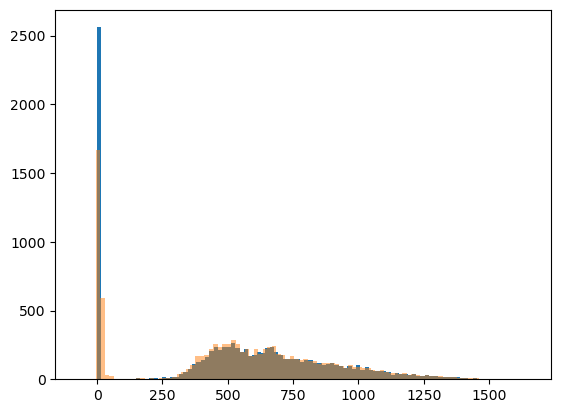

In [32]:
import matplotlib.pyplot as plt
plt.hist(pred,bins=100,alpha=1)
plt.hist(pd.read_csv('./lgb-nw.csv')['Income'],bins=100,alpha=0.5)
# plt.hist(train['Income'],bins=50)

In [68]:
sub = pd.read_csv('./open/sample_submission.csv', index_col=0)
sub['Income'] = pred
sub.to_csv('./lgb.csv')